In [1]:
import warnings

warnings.filterwarnings("ignore", category = RuntimeWarning)

## JP Morgan - Boston Housing Analysis - Team Yin

### Table of Contents

### Project Overview

In [30]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Exploratory Data Analysis (EDA)

This dataset originates from a 1976 study, "Hedonic Housing Prices and the Demand for Clean Air" by two Cambridge-based researchers, David Harrison Jr and Daniel Rubenfeld. The original study was designed to measure the willingness of the Boston populace to pay for clean air, using the median home value of towns and suburbs in the Boston area to measure this willingness. Other variables are used to structure the data, as well as to give context to the neighbourhoods and suburbs that this data describes.

The dataset consists of 506 rows, representing various neighbourhoods and suburbs in the Boston area. There are 14 attributes that each of these areas are measured on, with the final column, MEDV (median value of owner-occupied homes, in $10,000s) serving as the dependent variable. MEDV is truncated at 50, meaning that any areas with a median owner-occupied home value of at $500,000 or greater is listed as having a median value of $500,000. 

In [3]:
filepath = r'.\data\housing.csv'
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv(filepath, sep = '\s+', header = None, names = column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- CRIM: crime rate by town
- ZN: proportion of residential land in a town that is zoned for lots greater than 25,000 ft
- INDUS: proportion of land in a town that is non-retail business, by acre
- CHAS: a binary value, where 0 indicates that the area does not bound the Charles River and where 1 indicated that the area does bound the Charles River
- NOX: nitrogen oxide concentrations in parts per hundred million (pphm)
- RM: average number of rooms per owner-occupied home
- AGE: proportion of owner-occupied homes built prior to 1940
- DIS: a weighted value that represents distance to 5 major employment centres in the Boston area, measured logarithmically 
- RAD: accessibility to radial highways, by town, measured logarithmically
- TAX: full-value property tax rate, in $10,000s
- PTRATIO: ratio of students to teachers per school district
- B: proportion of the population that is Black, calculated by the formula 1000(B_k - 0.63)^2k)
- LSTAT: proportion of the population that is “lower status”, calculated by 0.5^(lower status proportion) 
- MEDV: median value of owner-occupied homes by town, in $10,000s


#### Data Quality and Ethics

Because of its origin point as a research study, this dataset has several data quality and data ethics issues to consider. 

1. Several columns are already transformed values.
2. Attempts to confirm data validity were unable to fully map the dataset back to the 1970 US Census.
3. Harrison and Rubenfeld assume a parabolic relaationship between MEDV and B, based on their belief that racial segregation increases housing values. They tranformed this data to fit this assumption, using 63% as the threshold where prices flip from declining to increasing. They did not provide any evidence to support this decision.
4. LSTAT was created by taking the number of "low status" individuals, which are defined as people who did not graduate high school or male laborers. This value is transformed logarithmically in a manner that values distinctions between higher social classes more than lower ones.
5. Most of this data is from the 1970 US census. Until the passing of the Fair Housing Act of 1968, it was legal to discriminate against potential renters and homeowners on the basis of race, religion, national origin, and sex. Use of this data to predict housing values runs the risk of reinforcing bias.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [5]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


#### Data Visualization

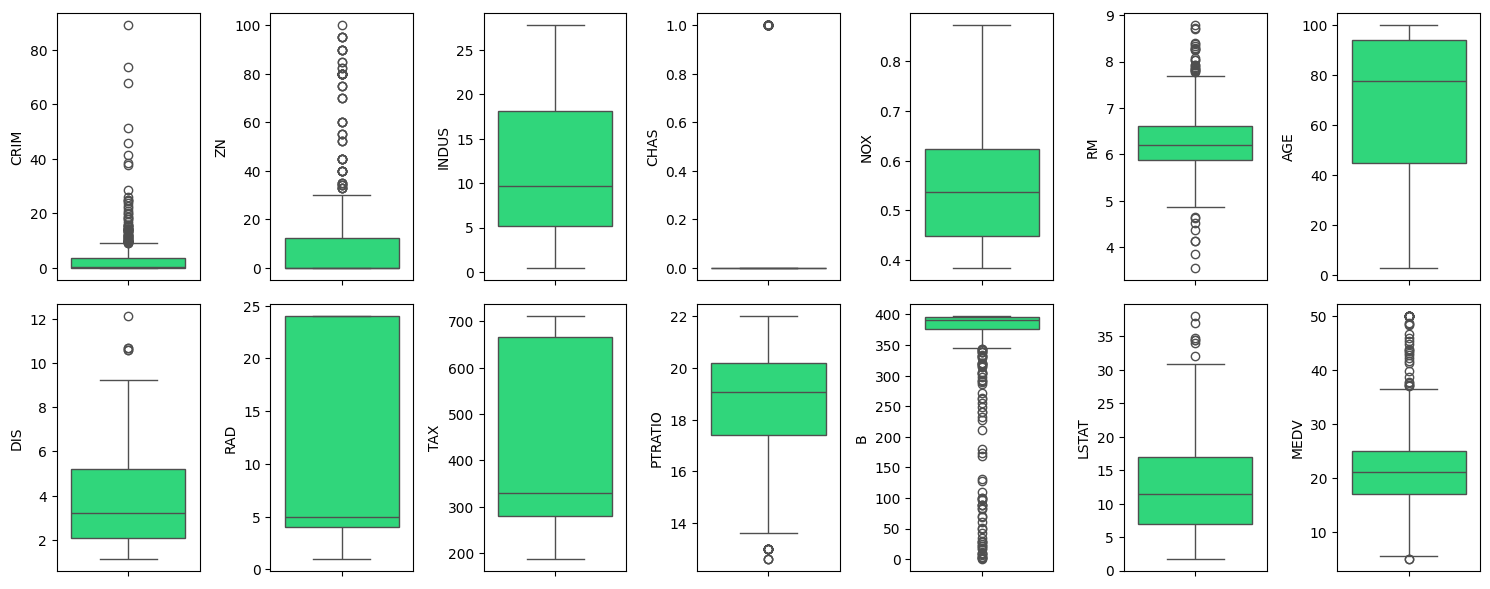

In [6]:
# Box and Whisker Plots
fig, axes = plt.subplots(nrows = 2, ncols = 7, figsize = (15, 6))

axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.boxplot(y = df[column], data = df, ax = axes[i], color = '#14F278')

plt.tight_layout()
plt.show()

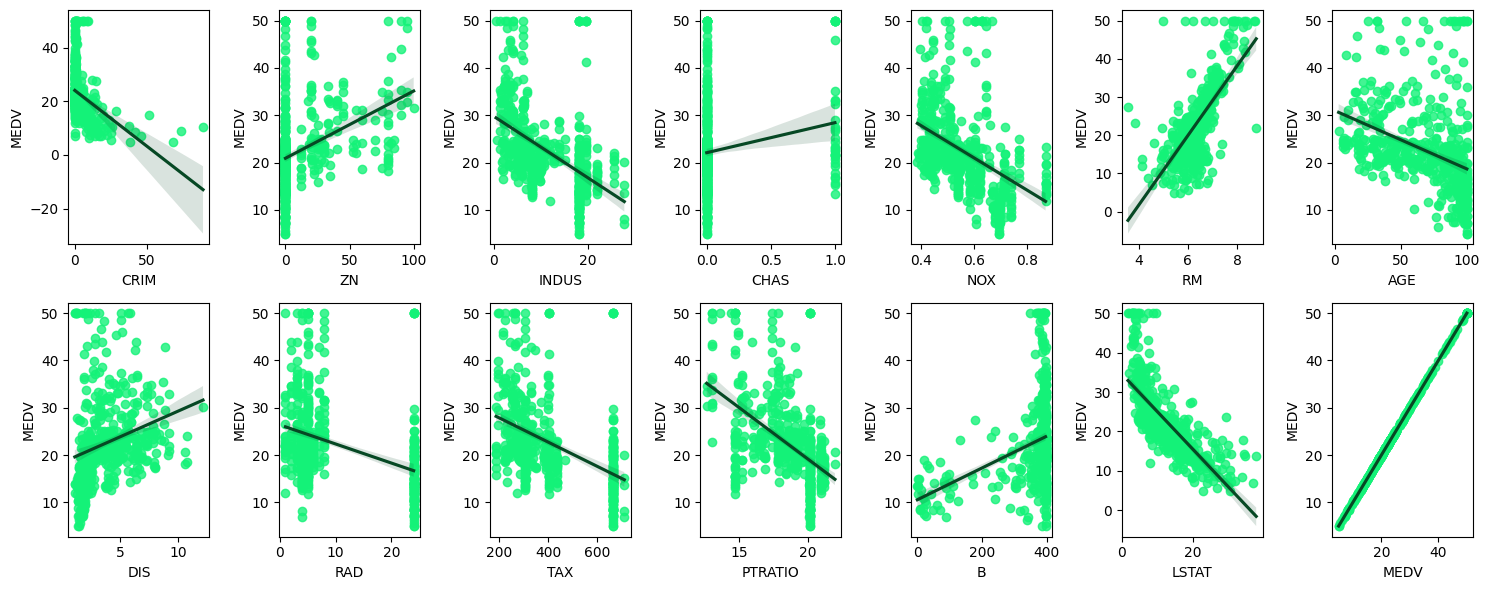

In [7]:
# Scatter Plots
fig, axes = plt.subplots(nrows = 2, ncols = 7, figsize = (15, 6))

axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.regplot(x = df[column], y = df['MEDV'], data = df, ax = axes[i], color = '#14F278', line_kws = dict(color = '#064824'))

plt.tight_layout()
plt.show()

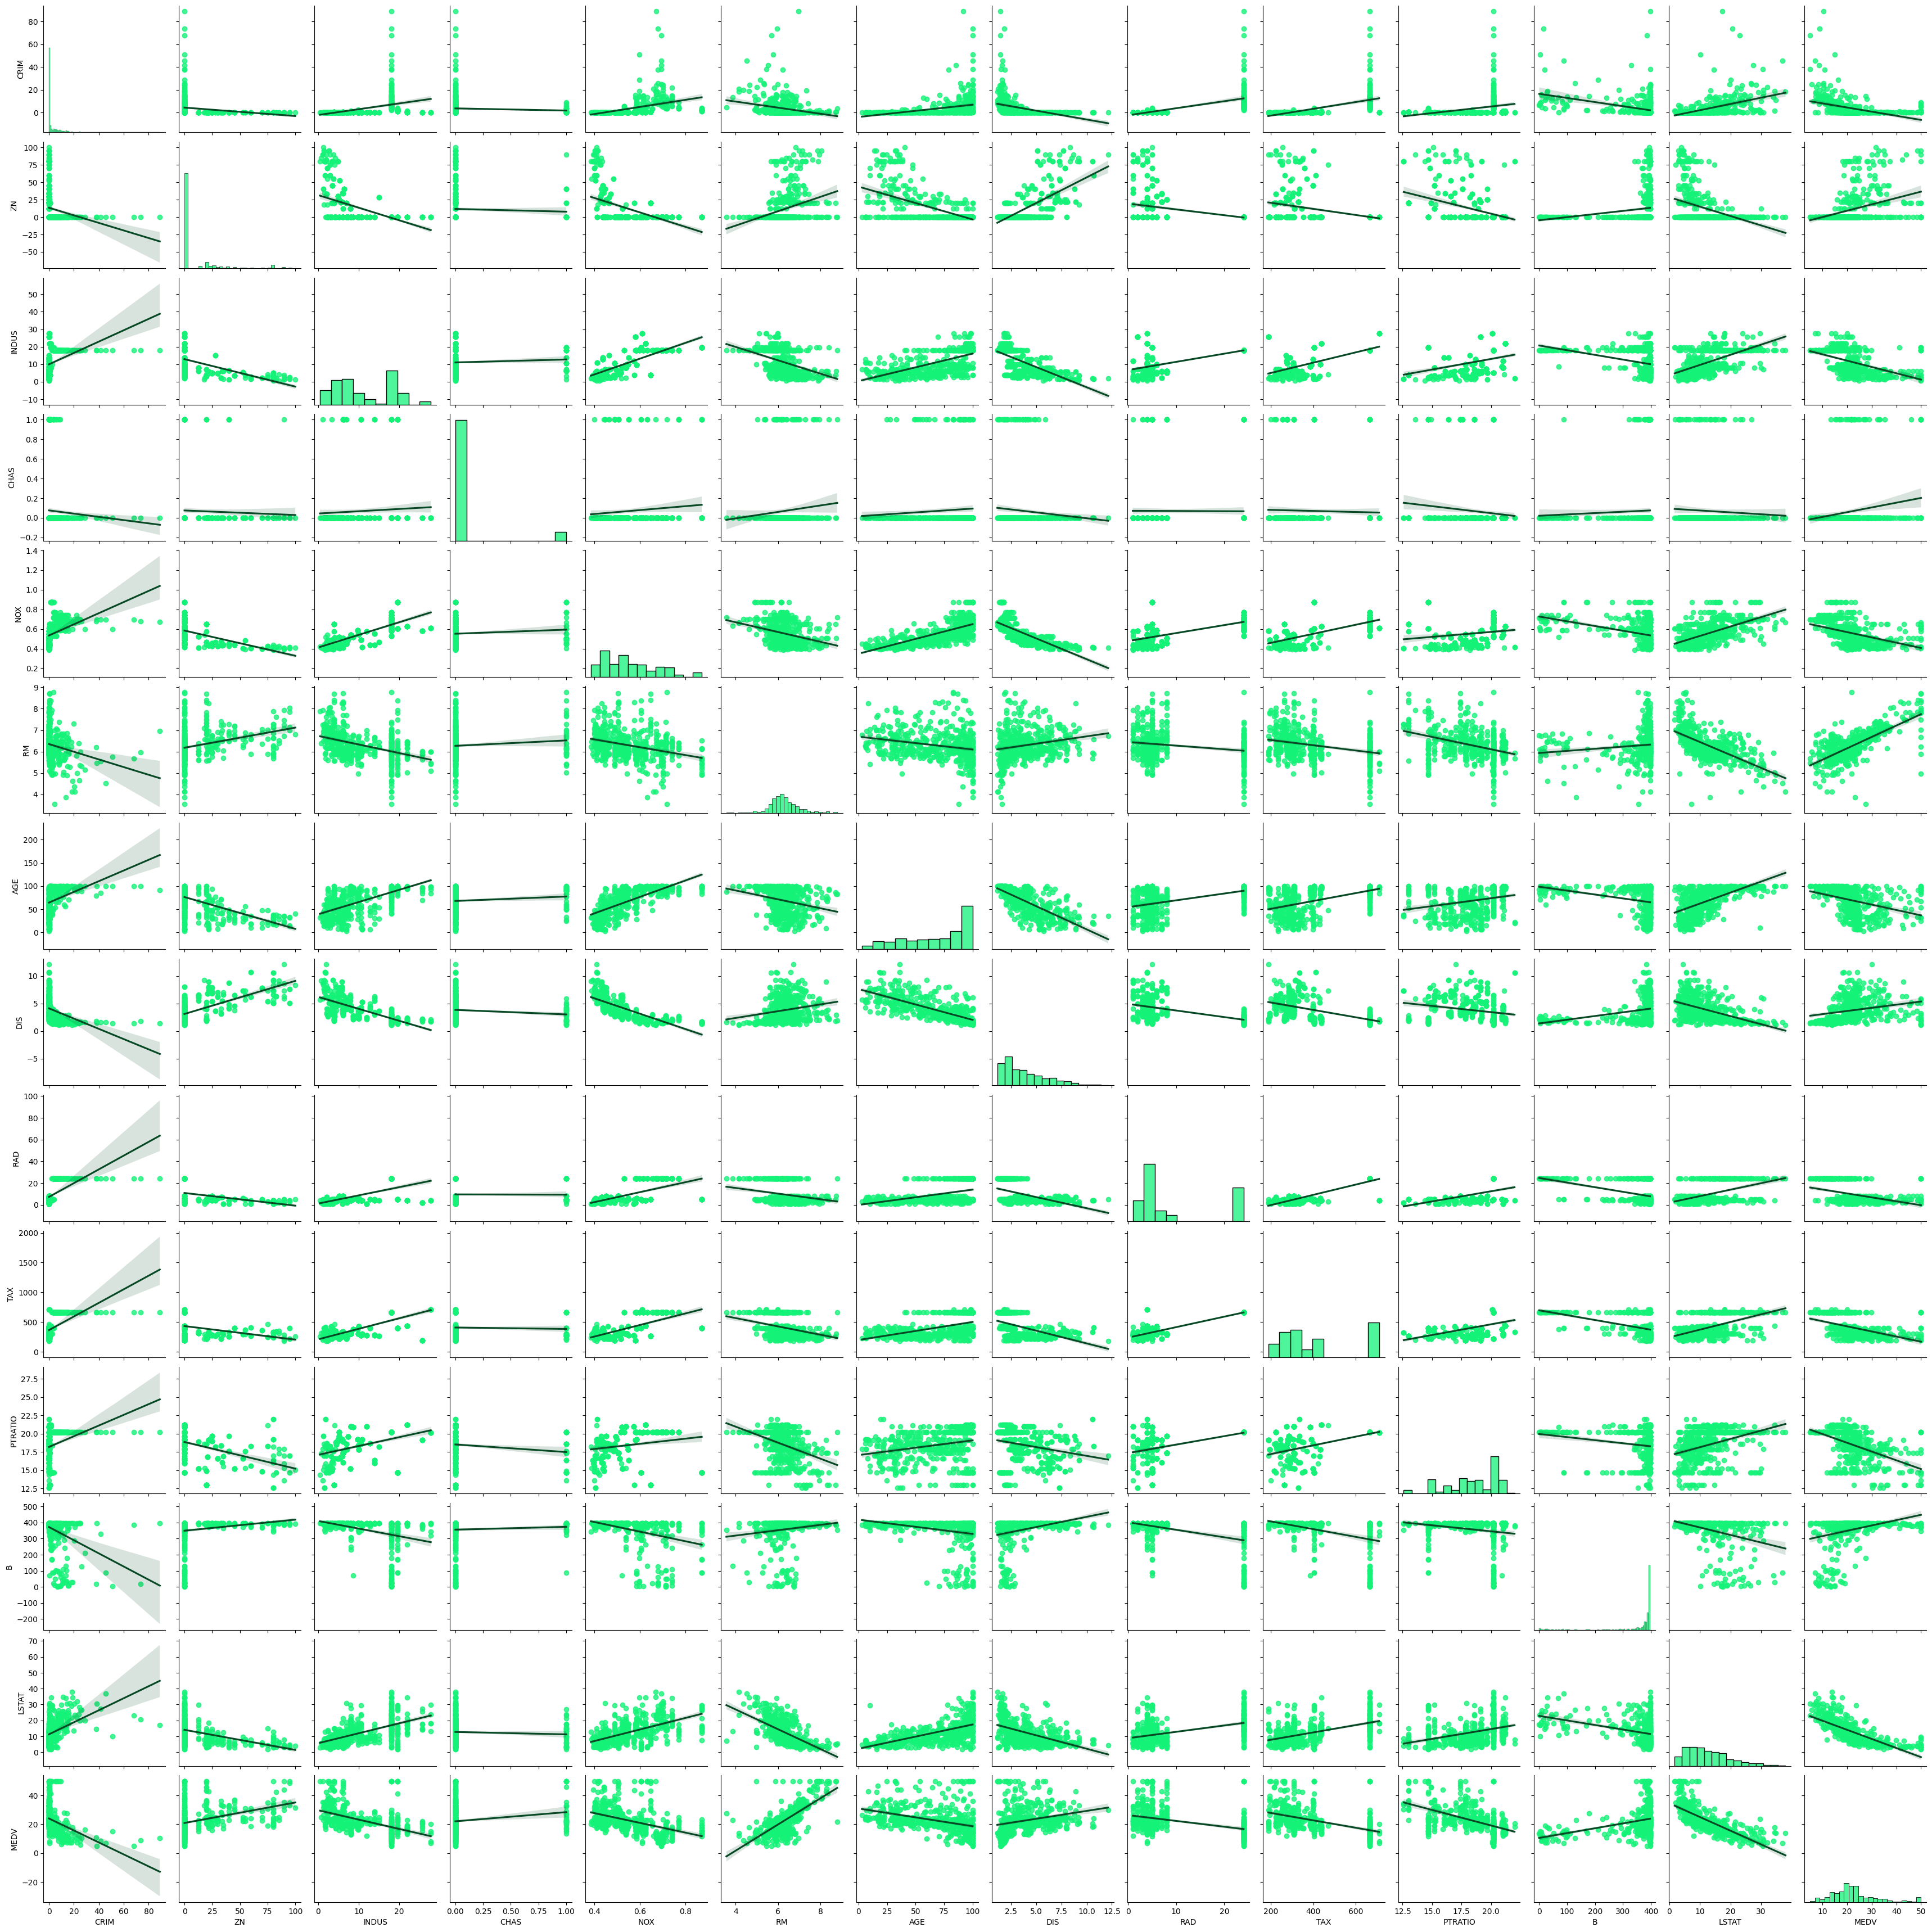

In [8]:
# Pairplot
pairplot = sns.pairplot(df, kind = 'reg', plot_kws={'color': '#14F278', 'line_kws': {'color': '#064824'}}, diag_kws={'color': '#14F278'})
plt.show()

#### Outliers

The first outliers we removed were based on research into the construction of the data. MEDV is truncated at 50, meaning that any towns with a median home value greater than 50 were assigned a value of 50. We removed all rows with MEDV values of 50 or above from the data to account for this.
 
Next, we looked at the box and whisker plots to identify potential outliers in the data. We compared the box and whisker plots to the scatterplots of the different features and MEDV to identify how these outliers affected MEDV. We removed rows where CRIM was greater than 60 from the data, as those are substantial outliers in the distribution of CRIM values, and MEDV does not decrease substancially after CRIM grows greater than 60. We also removed rows with RM values of less than 4. RM values of less than 4 correspond to a higher MEDV value compared to the rest of the data. Finally, we removed rows with DIS values greater than 10. This removed all outliers from DIS. By removing these values we avoid higher residuals as we work through the steps of the gradient boosting algorithim.
 
In accounting for the construction of the dataset, and by removing outliers that do not fit with general trends in the dataset, we improve the function of the gradient boosting aspect of the model. Rows with features that do not fit well to general trends have the potential to skew the resdiuals when applying gradient boosting, which would cause the model to give these outliers more importance than they are due. By removing these outliers, we create a more robust model that can generalize trends in the dataset without being overly affected by non-standard feature values.

In [9]:
df = df[~(df['MEDV'] >= 50.0)].reset_index(drop = True)
df = df[~(df['CRIM'] > 60)].reset_index(drop = True)
df = df[~(df['RM'] < 4)].reset_index(drop = True)
df = df[~(df['DIS'] > 10)].reset_index(drop = True)
df.shape

(480, 14)

#### Selecting Columns

The correlation heatmap calculates the correlation between the two intersecting variables, and is colored using the absolute value of the correlation. A deeper green indicates a stronger correlation, both negative and positive. MEDV is strongly correlated with LSTAT and RM, and also shows fairly strong correlation with CRIM, INDUS, NOX, AGE, RAD, TAX, and PTRATIO. Based on this matrix, ZN, CHAS, DIS, and B are not strong features for the model, as they do not have a strong relationship.

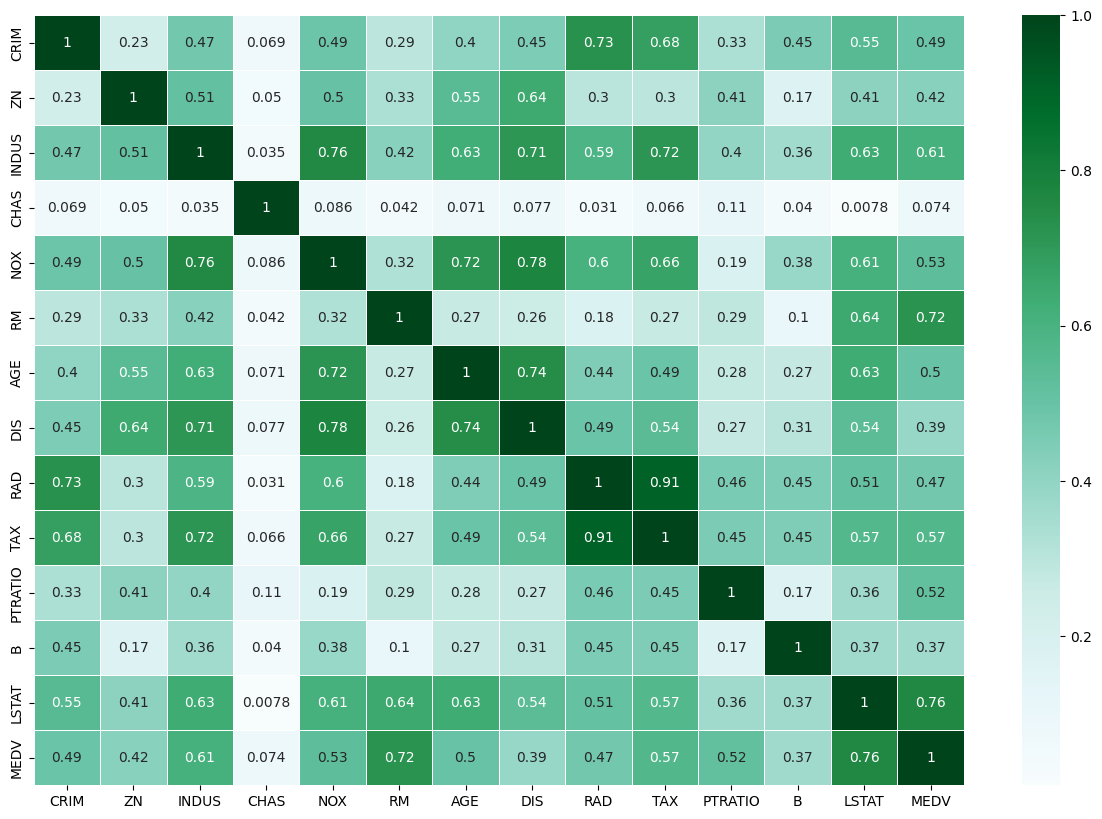

In [10]:
# Correlation Heatmap
corr_df = df.corr().abs()

fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(corr_df, annot = True, cmap = 'BuGn', linewidths = 0.5)
plt.show()

Multicovariance is a concern for the model, as some of these features influence each other as a natural factor of city planning. We seek to eliminate redundancy by identifying which features may affect others and removing them.
 
LASSO regression is a regression analysis method that is useful in the case of datasets with high multicolinearity. LASSO first uses a standard linear regression model on the dataset, then adds a penalty based on the absolute values of the coefficients. LASSO then works to find coefficients that minimize the sum of the squared error while also minimizing the penalty. As a result, some coeffients are shrunk towards zero while others become more prominent, indicating their usefulness as features. Here, the LASSO has identified RM, DIS, PTRATIO, and LSTAT as ideal features.

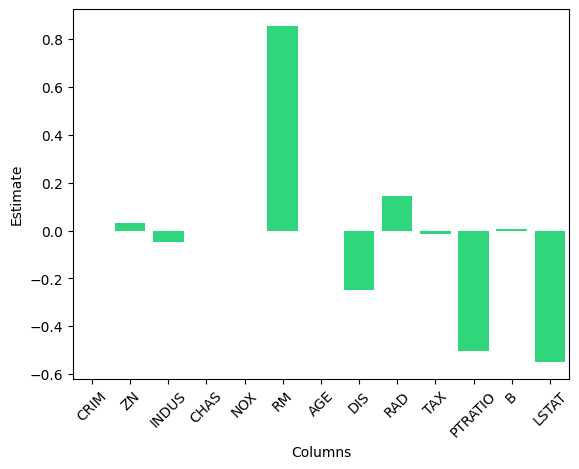

In [11]:
# Lasso Regression
X = df.drop(columns = ['MEDV'])
y = df['MEDV']
 
x_train, x_test, y_train, y_test = train_test_split(X, y,  test_size = 0.20, random_state = 42)
 
model = Lasso(alpha = 1)
model.fit(x_train, y_train)
y_pred1 = model.predict(x_test)
 
lasso = pd.DataFrame()
lasso['Columns'] = x_train.columns
lasso['Estimate'] = pd.Series(model.coef_)
 
sns.barplot(x = lasso['Columns'], y = lasso['Estimate'], color = '#14F278')
plt.xticks(rotation = 45)
plt.show()

Based on our analysis of the dataset, we identified RM, PTRATIO, TAX, and LSTAT as the features we wished to use to build our model. These features were first identified using the LASSO regression, and then by relating back to the correlation matrix. RM, PTRATIO, and LSTAT all showed up on the LASSO, and had fairly strong correlation with MEDV. While TAX was almost zeroed out on the LASSO, it has a good correlation with MEDV, unlike DIS. Additionally, many of the features that DIS is correlated with are also correlated with TAX, making TAX a strong feature to include in the model.


### sklearn Gradient Boosting Model

Gradient Boosted Trees (GBT) is a popular machine learning technique used for both regression and classification tasks. It's an ensamble learning method, meaning it combines the predictions of another model to improve overall performance.

Gradient boosting is a sequential technique where new models are added to correct the errors made by existing models. In each iteration, a new decision tree model is trained to predict the residuals (the differences between the actual values and the predictions of the ensemble so far).

A decision tree is a flowchart-like structure where each internal node represents a feature, each branch represents a decision based on that feature, and each leaf node represents the outcome or prediction.

The "gradient" in Gradient Boosting refers to the gradient descent optimization algorithm. It's used to minimize the loss function of the ensemble model. Gradient descent adjusts the parameters of the new model in the direction that reduces the loss the most.

Each new decision tree model is added to the ensemble, with its predictions weighted by a factor (learning rate) that determines how much influence it has on the final prediction. The learning rate is typically a small value, and it helps to prevent overfitting and stabilize the training process.

The process of adding new models continues until a predefined number of trees are added or until a stopping criterion is met, such as the maximum depth of the tree or the minimum number of samples in each node.

Overall, Gradient Boosted Trees are powerful and widely used due to their ability to capture complex relationships in data, handle missing values, and provide high predictive accuracy.

In [12]:
X = df[['RM', 'PTRATIO', 'TAX', 'LSTAT']]
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Initialize an instance of a Gradient Boosting Regression
model = GradientBoostingRegressor()

Hyperparameter tuning is the process of selecting the best set of hyperparameters for a machine learning algorithm to optimize its performance on a give dataset. Hyperparameters are values that specify the details of the learning process and help optimize the model. For our model, we used the maximum depth, minimum number of samples, learning rate, and number of estimators as the hyperparameters.

To find the best set of hyperparameters for our model, we decided to use GridSearchCV. GridSearchCV (Grid Search Cross-Validation) searches through a manually specified subset of hyperparameter combinations to find the best set for a given model.

In [13]:
# Pass ranges for Hyperparameters
parameters = {'max_depth': [2, 3, 4, 5, 6],
              'min_samples_split': [3, 4, 5, 6, 7],
              'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
              'n_estimators': [25, 50, 75, 100, 125, 150]}  

# Initialize a Grid Search object
clf = GridSearchCV(estimator = model, param_grid = parameters, cv = 5)

# Fit the Grid Search object to the train data
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

In [14]:
# Retrieve the optimal hyperparamer values, found by Grid Search CV
best_depth = clf.best_estimator_.max_depth
best_min_samples = clf.best_estimator_.min_samples_split
best_learning_rate = clf.best_estimator_.learning_rate
best_n_estimators = clf.best_estimator_.n_estimators

print(f'Best depth: {best_depth}')
print(f'Best minimum number of samples: {best_min_samples}')
print(f'Best learning rate: {best_learning_rate}')
print(f'Best number of estimators: {best_n_estimators}')

Best depth: 3
Best minimum number of samples: 3
Best learning rate: 0.1
Best number of estimators: 125


Mean Absolute Error (MAE) is 2.0670
Mean Squared Error (MSE) is 6.9001
Root Mean Squared Error (RMSE) is 2.6268
R-squared is 0.8863


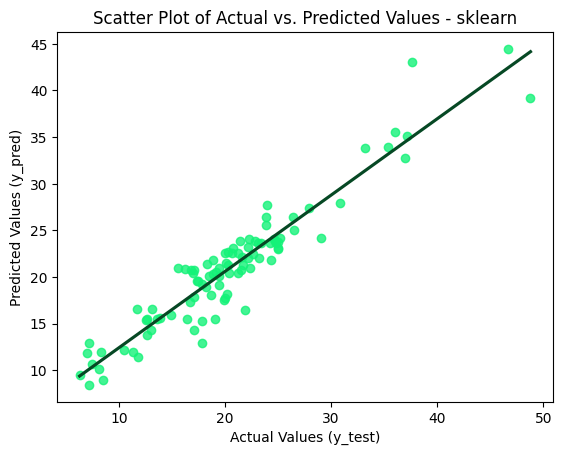

In [15]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE) is {mae:.4f}')
print(f'Mean Squared Error (MSE) is {mse:.4f}')
print(f'Root Mean Squared Error (RMSE) is {mse**0.5:.4f}')
print(f'R-squared is {r2:.4f}')

sns.regplot(x = y_test, y = y_pred, color = '#14F278', ci = 0, line_kws = {'color': '#064824'})
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of Actual vs. Predicted Values - sklearn")

plt.show()

### Gradient Boosting Model from Scratch



In [16]:
class Node():
    """This class defines the attributes of a tree node."""
    def __init__(self, feature = None, threshold = None, left = None, right = None, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

In [17]:
class DecisionTree():
    """Define a decision tree regressor.
    
    Args:
        min_samples (int, optional): The minimum number of samples required to split an
        internal node. Defaults to 5.
        max_depth (int, optional): The maximum depth of the tree. Defaults to 3.
    """
    def __init__(self, min_samples: int = 5, max_depth: int = 3):
        # Initialize DecisionTree object with specified prarmeters
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.root = None

    def _best_split(self, X: pd.DataFrame, y: pd.DataFrame) -> tuple:
        """Find the best threshold and index to split the node on."""
        # Initialie variables to track the best split
        best_mse = float('inf')
        best_feature = None
        best_threshold = None
        n_features = X.shape[1]

        # Iterate over features to find the best split
        for feature_i in range(n_features):
            for threshold in np.unique(X[:, feature_i]):
                left_mask = X[:, feature_i] <= threshold
                right_mask = X[:, feature_i] > threshold
                mse = self._mse(y, left_mask, right_mask)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_i
                    best_threshold = threshold

        return best_feature, best_threshold

    def _mse(self, y, left_mask, right_mask) -> float:
        """Calculate the total Mean Squared Error (MSE) for the right and left nodes."""
        left = y[left_mask]
        right = y[right_mask]
        mse_left = self._mean_squared_error(left)
        mse_right = self._mean_squared_error(right)

        total_samples = len(left) + len(right)
        total_left = (len(left) / total_samples) * mse_left
        total_right = (len(right) / total_samples) * mse_right

        return total_left + total_right

    def _mean_squared_error(self, y):
        """Calculate the Mean Sqaured Error (MSE)."""
        if len(y) == 0:
            return 0
        mean = np.mean(y)
        return np.mean((y - mean) ** 2)
    
    def _grow_tree(self, X: np.array, y: np.array, depth: int = 0) -> Node:
        """Split the data into leaf nodes."""
        # Check if further splitting is necessary
        n_samples = X.shape[0]
        if n_samples >= self.min_samples and depth <= self.max_depth:
            # Find the best split for the current node
            index, threshold = self._best_split(X, y)
            left_mask = X[:, index] <= threshold
            right_mask = X[:, index] > threshold

            # Recursively grow the left and right subtrees
            left = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
            right = self._grow_tree(X[right_mask], y[right_mask], depth + 1)

            # Define a parent node with the best split
            return Node(feature = index, threshold = threshold, left = left, right = right)

        # Define a leaf node with the mean value of the target variable
        return Node(value = self._leaf_node(y))

    def _leaf_node(self, y) -> float:
        """Calculate the value of a leaf node."""
        return np.mean(y)

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        """Build a decision tree regressor from the training set (X, y)."""
        # Convert input DataFrame to numpy array
        X = X.to_numpy()
        # Grow the decision tree
        self.root = self._grow_tree(X, y)

    def predict(self, X: pd.DataFrame) -> list:
        """Predict the y values."""
        # Convert input DataFrame to numpy array
        X = X.to_numpy()
        # Predict the target values for the input data
        return [self._traverse(x, self.root) for x in X]

    def _traverse(self, x: np.array, node: Node) -> float:
        """Traverse the decision tree to find the predicted value for input data point."""
        if node.value is None:
            if x[node.feature] <= node.threshold:
                return self._traverse(x, node.left)
            return self._traverse(x, node.right)
        return node.value

In [18]:
class ScratchGradientBoostingRegressor():
    """Define a gradient boosting regressor."""
    def __init__(self, max_depth = 3, min_samples = 5, learning_rate = 0.1, n_estimators = 50):
        # Initialize GradientBoostingRegressor object with specified parameters
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators

        # Initialize list to hold DecisionTree models
        self.trees = []
        # Create decision trees as base estimators
        for _ in range(n_estimators):
            tree = DecisionTree(min_samples = self.min_samples, max_depth = self.max_depth)
            self.trees.append(tree)

    def fit(self, X, y):
        """Build a gradient boosting regressor from the training set (X, y)."""
        # Initialize predictions with actual y values
        y_pred = np.copy(y)
        # Iterate over each decision tree
        for tree in self.trees:
            # Fit the tree to the data and residuals
            tree.fit(X, y_pred)
            # Make predictions using the current tree
            new_y_pred = tree.predict(X)
            # update predictions with scaled residuals
            y_pred = y_pred - np.multiply(self.learning_rate, new_y_pred)

    def predict(self, X):
        """Predict the y values."""
        # Initialize predictions with zeros
        y_pred = np.zeros(X.shape[0])
        # Iterate over each decision tree
        for tree in self.trees:
            # Make predictions using the current tree
            new_y_pred = tree.predict(X)
            # Update predictions by adding scaled predictions
            y_pred += np.multiply(self.learning_rate, new_y_pred)
        return y_pred

#### Performance Metrics
We calculated a few of the basic performance metrics from scratch to evaluate our model with, including Mean Absolute Error, Mean Squared Error, and the sum of the squared residuals.

In [19]:
def mae_val(y, y_pred):
    """Calculate Mean Absolute Error."""
    return np.mean(abs(y - y_pred))

def mse_val(y, y_pred):
    """Calculate Mean Square Error."""
    return np.mean(np.square(np.subtract(y, y_pred)))

def r_square(y, y_pred):
    """Calculate R-Squared."""
    ssr = np.sum(np.square(np.subtract(y, y_pred)))
    sst = np.sum(np.square(np.subtract(y, np.mean(y))))
    return 1 - ssr/sst

def performance_evaluation(y, y_pred):
    """Print all the performance metrics."""
    mae = mae_val(y, y_pred)
    mse = mse_val(y, y_pred)
    r2 = r_square(y, y_pred)

    print(f'Mean Absolute Error (MAE) is {mae:.4f}')
    print(f'Mean Squared Error (MSE) is {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE) is {mse**0.5:.4f}')
    print(f'R-squared is {r2:.4f}')

#### Train Test Split

This is our version of the sklearn train_test_split method. We included a random seed so that you can reproduce the same random dataset for testing.

In [20]:
def train_test(X, y, train_size: float = 0.8, seed: int = None):
    """Split the dataset into train and tests sets."""
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Get number of samples
    num_samples = len(X)

    # Create shuffled indices
    index = np.arange(num_samples)
    np.random.shuffle(index)

    # Shuffle X and y using shuffled indices
    X = X.loc[index]
    y = y.loc[index]

    # Detemine split inde based on train size
    split_i = int(num_samples * train_size)

    # Split dataset into train and test sets
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

#### K Fold

The k-fold method is a tool used in hyperparameter tuning that allows you to split up the data into multiple subsets or "folds" and then treat each individual subset as the validation, or testing set. The other subsets are treated as the trainning set for the model to fit on. This method is useful as it reduces the variance and bias of the predicted target values. It also accounts for the variability of the test set.

In [27]:
def k_fold(model, X, y, n_folds, seed: int = None):
    # You can set the seed or the random state so that you can reproduce the same results
    if seed is not None:
        np.random.seed(seed)
 
    # This randomly shuffles the indexes of the DataFrame
    index = list(np.arange(len(X)))
    np.random.shuffle(index)
 
    # the results will be saved in lists to be returned later
    results = []
    predictions = []
    y_tests = []
 
    # the for loop will goes through every fold, setting a new subset as the testing every time
    for i in range(n_folds):
        # the marker is the cutoff point between the testing and training subsets
        marker = int(len(X)/n_folds)
 
        # This ensures that each testing set has no overlap with the others
        testing_index = index[marker * i : marker * (i+1)]
        training_index = index[:marker * i] + index[marker * (i+1):]
 
        # There will be a remainder of rows that will be added to the last subset
        if i == (n_folds - 1):
            testing_index += index[marker * (i+1):]
            training_index = training_index[:marker* i]
 
        # Using the calculated indices to make dataframes
        X_train = X.loc[training_index]
        X_test = X.loc[testing_index]
        y_train = y.loc[training_index]
        y_test = y.loc[testing_index]
       
        # This is where we use the model to get predictions and a r2 score
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r_square(y_test, y_pred)
 
        # Saving the results of each run to be returned later
        predictions.append(y_pred)
        y_tests.append(y_test)
        results.append(r2)
   
    # we return the y_test and y_preds so that each fold can be graphed out later
    return np.mean(results), y_tests, predictions

### Grid Search CV

Our version of Grid Search hyperparameter tuning method finds all of the possible combinations of the hyperparameters and then runs the model on all of the different combinations to find the optimal combination that produces the most positive results. There is also a input parameter for the number of folds to be used if you want to utilize k-fold cross validation. 

In [28]:
def grid_search(parameters, X_train, X_test, y_train, y_test, n_folds:int = 0, seed: int = None, train_size: float = 0.8):
    # This counter is used to track the progress of the function as it runs
    count = 0
 
    # These dataframes will be used if the function is run with k_folds
    X1 = pd.concat([X_test, X_train])
    y1 = pd.concat([y_train, y_test])
 
    # keeping track of the best hyperparameters to be returned later
    best_r2 = 0
    best_y_pred = []
    best_y_test = []
    best_combo = 0
 
    # this will give a list of all unique combinations of the hyperparameters
    param_combinations = list(itertools.product(*parameters.values()))
    for combo in param_combinations:
        #printing the counter to keep track of the function progress
        count += 1
        print(f'combination: {combo}', end='\r')
        # Using our from scratch gradient boosing model with the hyperparameters of this for loop run
        model = ScratchGradientBoostingRegressor(**dict(zip(parameters.keys(), combo)))
       
        y_pred = None
        r2 = 0
 
        # if n_folds is not zero then the parameters are sent to the k_folds function otherwise
        if n_folds > 0:
            r2, y_test, y_pred = k_fold(model, X1, y1, n_folds, seed)
        else:
            # if you don't use k_folds then the model is run once per parameter combination
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r_square(y_test, y_pred)
 
        # keeps track of the best model based on its r2 score
        if r2 > best_r2:
            best_r2 = r2
            best_combo = combo
            best_y_pred = y_pred
            best_y_test = y_test
 
    # returns the parameters and r2 with of the best model as well as the y scores to be used in a graph
    return best_r2, best_combo, best_y_pred, best_y_test

In [35]:
X = df[['RM', 'PTRATIO', 'TAX', 'LSTAT']]
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test(X, y, train_size = 0.8, seed = 42)

parameters = {'max_depth': [2, 3],
              'min_samples': [3, 4, 5],
              'learning_rate': [0.05, 0.1],
              'n_estimators': [100, 125, 150]}  

best_r2, best_params, y_pred, y_test = grid_search(parameters, X_train, X_test, y_train, y_test, n_folds = 5, seed = 42)

In [36]:
print(f'Best depth: {best_params[0]}')
print(f'Best minimum number of samples: {best_params[1]}')
print(f'Best learning rate: {best_params[2]}')
print(f'Best number of estimators: {best_params[3]}')

Best depth: 2
Best minimum number of samples: 4
Best learning rate: 0.1
Best number of estimators: 150


Sample 1
Mean Absolute Error (MAE) is 2.1850
Mean Squared Error (MSE) is 8.4101
Root Mean Squared Error (RMSE) is 2.9000
R-squared is 0.8132
Sample 2
Mean Absolute Error (MAE) is 2.2899
Mean Squared Error (MSE) is 9.4180
Root Mean Squared Error (RMSE) is 3.0689
R-squared is 0.7783
Sample 3
Mean Absolute Error (MAE) is 2.2248
Mean Squared Error (MSE) is 10.2357
Root Mean Squared Error (RMSE) is 3.1993
R-squared is 0.8441
Sample 4
Mean Absolute Error (MAE) is 2.1275
Mean Squared Error (MSE) is 8.5616
Root Mean Squared Error (RMSE) is 2.9260
R-squared is 0.8609
Sample 5
Mean Absolute Error (MAE) is 2.2851
Mean Squared Error (MSE) is 12.4892
Root Mean Squared Error (RMSE) is 3.5340
R-squared is 0.8001


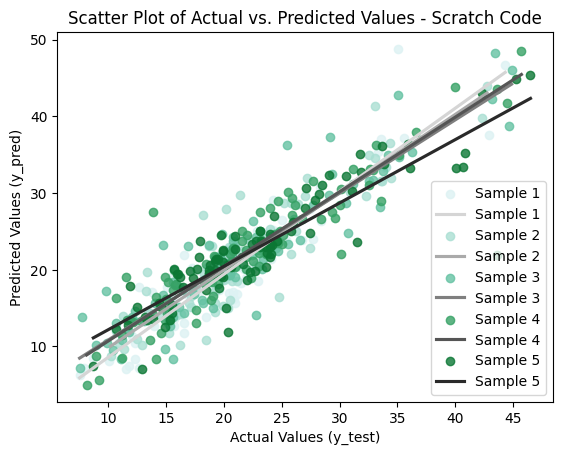

In [37]:
if type(y_pred) == list:
    for i, (test, pred) in enumerate(zip(y_pred, y_test)):
        print(f'Sample {i+1}')
        performance_evaluation(test, pred)
        color = sns.color_palette('BuGn', n_colors = len(y_pred))[i]
        line_color = sns.color_palette('binary', n_colors = len(y_pred))[i]
        sns.regplot(x = test, y = pred, color = color, ci = 0, line_kws = {'color': line_color, 'label': f'Sample {i+1}'}, label = f'Sample {i+1}')
    
    plt.xlabel("Actual Values (y_test)")
    plt.ylabel("Predicted Values (y_pred)")
    plt.title("Scatter Plot of Actual vs. Predicted Values - Scratch Code")
    plt.legend()
    plt.show()

else:
    sns.regplot(x = y_test, y = y_pred, color = '#14F278', ci = 0, line_kws = {'color': '#064824'}, label = 'Samples')
    plt.xlabel("Actual Values (y_test)")
    plt.ylabel("Predicted Values (y_pred)")
    plt.title("Scatter Plot of Actual vs. Predicted Values - Scratch Code")
    plt.legend()
    plt.show()


### Conclusion

#### sklearn vs Scratch Model Comparison

We must be aware of the effect that randomness has on the model. Using one random seed might select a set of training data that is ideally suited to the test data, resulting in a model that seems to predict the data extremely well, while another random seed might select data that does the opposite. Relying on one random seed to ascertain the true capabilities of the model would be unwise.
 
To better identify the true performance of the model, we developed a function that generates a list of random seeds, splits the data based on that random seed, and then runs both models on that data split and compares their performance. As we run more random samples, we will approach closer to the true average. We cannot fully account for the effect of randomness in the model, but we can use the average of multiple model performances to approximate the true performance.

In [38]:
def random_run(X, y, low=1, high=500, size=10):
    # Generate a list of random integers to serve as seeds
    random_list = np.random.randint(low, high, size)
    # Lists to store evaluation metrics for custom build
    mae_ours = []
    mse_ours = []
    r2_ours = []
    # Lists to store evaluation metrics for scikit-learn build
    mae_sklearn = []
    mse_sklearn = []
    r2_sklearn = []
    # Initialize custom and scikit-learn gradient boosting regressors
    model = ScratchGradientBoostingRegressor(max_depth=best_params[0], min_samples_split=best_params[1],
                                             learning_rate=best_params[2], n_estimators=best_params[3])
    model2 = GradientBoostingRegressor(max_depth=clf.best_estimator_.max_depth, min_samples=clf.best_estimator_.min_samples_split,
                                       learning_rate=clf.best_estimator_.learning_rate, n_estimators=clf.best_estimator_.n_estimators)

 
    # Iterate over each random seed
    for random_state in random_list:
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test(X, y, train_size=0.8, seed=random_state)
        # Fit custom build on training data
        model.fit(X_train, y_train)
        # Evaluate custom built on test data
        y_pred = model.predict(X_test)
        mae_ours.append(mae_val(y_test, y_pred))
        mse_ours.append(mse_val(y_test, y_pred))
        r2_ours.append(r_square(y_test, y_pred))
        # Fit scikit-learn build on training data
        model2.fit(X_train, y_train)
        # Evaluate scikit-learn build on test data
        y_pred2 = model2.predict(X_test)
        mae_sklearn.append(mae_val(y_test, y_pred2))
        mse_sklearn.append(mse_val(y_test, y_pred2))
        r2_sklearn.append(r_square(y_test, y_pred2))
 
    # Calculate differences in evaluation metrics between scikit-learn and custom build
    our_mae = sum(mae_ours) / len(mae_ours)
    sklearn_mae = sum(mae_sklearn) / len(mae_sklearn)
    our_mse = sum(mse_ours) / len(mse_ours)
    sklearn_mse = sum(mse_sklearn) / len(mse_sklearn)
    our_r2 = sum(r2_ours) / len(r2_ours)
    sklearn_r2 = sum(r2_sklearn) / len(r2_sklearn)
    mae_diff = our_mae - sklearn_mae
    mse_diff = our_mse - sklearn_mse
    r2_diff = sklearn_r2 - our_r2
 
    # Print the evaluation metrics and differences
    print("sklearn mae:", sklearn_mae, "our mae:", our_mae)
    print("difference in mae:", mae_diff)
    print("sklearn mse:", sklearn_mse, "our mse:", our_mse)
    print("difference in mse:", mse_diff)
    print("sklearn r2:", sklearn_r2, "our r2:", our_r2)
    print("difference in r2:", r2_diff)

In [39]:
random_run(X, y)

sklearn mae: 2.1844260580378116 our mae: 2.254675822942151
difference in mae: 0.07024976490433943
sklearn mse: 8.729526068779577 our mse: 9.565158303151481
difference in mse: 0.8356322343719036
sklearn r2: 0.8659233690327323 our r2: 0.8547186484983831
difference in r2: 0.011204720534349177
